# K-Nearest Neighbors (KNN) Implementation 
----
This code allows you to select a school district and locate its K nearest neighbors. 
 

## Importing necessary packages, lists, and functions 

In [103]:
import os
import pandas as pd
import numpy as np
import matplotlib as plt

Importing demographic buckets from Demographic_Buckets.py file (Demographic buckets to run model on)

In [104]:
os.chdir(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\4_Data_Modeling\4.2_KNN_Clustering")
from Demographic_Buckets import student_teacher_ratio
from Demographic_Buckets import student_count
from Demographic_Buckets import staff_count
from Demographic_Buckets import race_ethnicity_percent
from Demographic_Buckets import economically_disadvantaged
from Demographic_Buckets import special_ed_504
from Demographic_Buckets import language_education_percent
from Demographic_Buckets import special_populations_percent
from Demographic_Buckets import gifted_students
from Demographic_Buckets import district_identifiers

Importing modeling functions from the KNN_Model.py file (containing all functions used for this analysis)

In [105]:
from KNN_Model import calculate_missing_percentage
from KNN_Model import drop_columns
from KNN_Model import preprocess_data
from KNN_Model import knn_distance
from KNN_Model import knn_cosine
from KNN_Model import knn_canberra
from KNN_Model import find_nearest_districts
from KNN_Model import get_neighbor_data

Importing diagnostic plot functions from the KNN_Diagnostic_Plots.py file (containing all functions used for this analysis)

In [106]:
from KNN_Diagnostic_Plots import plot_texas_districts
from KNN_Diagnostic_Plots import plot_race_ethnicity_stacked_bar
from KNN_Diagnostic_Plots import plot_class_size_k6_bar
from KNN_Diagnostic_Plots import plot_special_ed_504_bar

## Reading in Data & Cleaning

In [107]:
#Reading in the data
os.chdir(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\4_Data_Modeling\4.2_KNN_Clustering")
df = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.7Master_Files\Individual Year Files_Take2\merged_2023.csv")
distgrad = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distgrad_2023_clean.csv")
distprof = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distprof_2023_clean.csv")
df = df[df['Charter School (Y/N)'] == 'N']
demographic_df = df[student_teacher_ratio + student_count + staff_count + race_ethnicity_percent + economically_disadvantaged +
                    special_ed_504 + language_education_percent + special_populations_percent + gifted_students +
                    district_identifiers]

# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Replace negative values with NaN only in numeric columns
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0, np.nan)


#plt.hist(calculate_missing_percentage(demographic_df) / 100)
#plt.title("Histogram of percentage of NA values in columns within demographic attributes")
#demographic_df


## Selecting the distance metric that finds nearest neighbors that are "internally similar" across multiple target districts and features
---  
Methodology:  
* Curate 3–5 meaningful feature sets
* Sample 10–20 diverse anchor districts
* Loop over distance metrics + feature sets
* Use internal similarity (avg pairwise distance) to score
* Pick best-performing metric
* (Optional) sanity-check a few neighbor outputs

Step1: Curated 4 meaningful feature sets including 
* Basic 
* Demographic heavy feature set 
* Support Services heavy feature set 
* All features 

In [108]:
feature_sets = {
    'basic': student_teacher_ratio + 
              student_count +
              staff_count,
    
    'demographics': 
        race_ethnicity_percent + 
        economically_disadvantaged +
        language_education_percent +
        special_populations_percent 
    ,
    
    'support_services': 
        special_ed_504 + 
        gifted_students +
        language_education_percent +
        special_populations_percent
    ,
    
    'all_features': 
        student_teacher_ratio + 
        student_count +
        staff_count +
        race_ethnicity_percent +
        economically_disadvantaged +
        special_ed_504 +
        language_education_percent +
        special_populations_percent +
        gifted_students
    
}

Step 2: Select 30 anchor districts.  
Anchor districts are determined using proportional stratified sampling across the entire 2023 dataset. Stratification is a tool that tries to take a representative sample of a whole df based on specified columns. Stratification works because it keeps the sample small enoguh to compute, but diverse enough to trust your results
   
Districts are stratified based on
* TEA Description: 8 columns outline what type of area district is in (Suburban, Urban, etc)
* Region: 1-20 major state/region groupings determined by the TEA (San Antonio, Houston, etc) 

In [109]:
# Strip quotes and whitespace from REGION column if needed
df['REGION'] = df['REGION'].str.strip().str.replace("'", "")

# Group by REGION and TEA Description, then sample 1 from each group
grouped = df.groupby(['REGION', 'TEA Description'])

# Sample 1 district from each unique group (if enough data exists)
anchor_districts = grouped.apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# Optional: Limit to 30 districts for feasibility
anchor_df = anchor_districts.sample(n=30, random_state=42) if len(anchor_districts) > 30 else anchor_districts

# Get district IDs
anchor_ids = anchor_df['DISTRICT_id'].tolist()



C:\Users\mmath\AppData\Local\Temp\ipykernel_18008\1514667669.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  anchor_districts = grouped.apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


Step 3: Loop over distance metrics + feature sets 
* Iteratue over each feature set (step 1)
* For each feature set, try each distance metric 
* For each combo, run find_nearest_districts() on every anchor district 
* Collect the neighbor district id

In [110]:
results = []
distance_metrics = [
    'euclidean',
    'manhattan',
    'mahalanobis',
    'cosine']


for feature_name, features in feature_sets.items(): # Gathering all 4 of the feature combinations 
    for metric in distance_metrics: # Getting all 4 different distance metrics 
        for anchor_id in anchor_ids: #Gett all 30 specific districts
            try:
                neighbors = find_nearest_districts(df, anchor_id, features, 5, metric, "median") #running the neighbors code given the parameters 
                # Saving results to easy to manipulate dataframe 
                results.append({
                    'anchor_id': anchor_id,
                    'feature_set': feature_name,
                    'distance_metric': metric,
                    'neighbor_ids': list(neighbors['DISTRICT_id']), 
                    'neighbor_distname': list(neighbors['DISTNAME'])
                })
            except Exception as e:
                print(f"Failed for anchor {anchor_id} with {metric} on {feature_name}: {e}")

neighbor_results = pd.DataFrame(results)
neighbor_results


,anchor_id,feature_set,distance_metric,neighbor_ids,neighbor_distname
0,233901,basic,euclidean,"[233901, 15911, 101924, 227913, 159901]","[SAN FELIPE-DEL RIO CISD, EAST CENTRAL ISD, SH..."
1,13901,basic,euclidean,"[13901, 146906, 84908, 187907, 71904]","[BEEVILLE ISD, LIBERTY ISD, HITCHCOCK ISD, LIV..."
2,34905,basic,euclidean,"[34905, 127901, 157901, 183901, 34907]","[LINDEN-KILDARE CISD, ANSON ISD, MASON ISD, BE..."
3,227901,basic,euclidean,"[227901, 170902, 79907, 220905, 101902]","[AUSTIN ISD, CONROE ISD, FORT BEND ISD, FORT W..."
4,158901,basic,euclidean,"[158901, 15909, 247903, 161906, 247901]","[BAY CITY ISD, SOMERSET ISD, LA VERNIA ISD, LA..."
...,...,...,...,...,...
475,94902,all_features,cosine,"[94902, 46902, 20908, 43907, 199901]","[SCHERTZ-CIBOLO-U CITY ISD, COMAL ISD, PEARLAN..."
476,15907,all_features,cosine,"[15907, 31901, 101911, 101903, 240903]","[SAN ANTONIO ISD, BROWNSVILLE ISD, GOOSE CREEK..."
477,123910,all_features,cosine,"[123910, 57907, 212905, 246906, 57910]","[BEAUMONT ISD, DUNCANVILLE ISD, TYLER ISD, HUT..."
478,39902,all_features,cosine,"[39902, 102906, 221904, 161918, 234903]","[HENRIETTA ISD, ELYSIAN FIELDS ISD, MERKEL ISD..."


Step 4: For each anchor district + feature set + distnace metric combo, evaluate how similar the 5 neighbors are to eachother  

This will tell us how cohesive/tight the neighborhood is - a tight cluster means that the distance metric is doing a good job. 

Specifically, sklearn.metrics.pairwise_distances will be used to compute the average pairwise distance among the 5 neighbors in the same feature space used to find them 

In [111]:
from sklearn.metrics import pairwise_distances
import numpy as np

def internal_similarity_score(df, neighbor_ids, feature_list, metric):
    """
    Computes average pairwise distance between a list of neighbor districts 
    using selected features and a distance metric.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Full dataset of districts.
    neighbor_ids : list
        List of DISTRICT_id values (including or excluding anchor).
    feature_list : list
        List of feature column names to compare.
    metric : str
        Distance metric to use: 'euclidean', 'manhattan', etc.

    Returns:
    --------
    float
        Average pairwise distance between all neighbors (excluding anchor if needed).
        Returns np.nan if fewer than 2 valid rows after dropna.
    """

    # Subset and filter out missing values
    data = df[df['DISTRICT_id'].isin(neighbor_ids)][feature_list].dropna()

    # Require at least 2 districts to calculate pairwise distance
    if data.shape[0] < 2:
        return np.nan

    # Compute pairwise distance matrix
    dists = pairwise_distances(data, metric=metric.lower())

    # Extract upper triangle of the matrix (no diagonal)
    upper_triangle = dists[np.triu_indices_from(dists, k=1)]

    return upper_triangle.mean()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances


def internal_similarity_score(df, neighbor_ids, feature_list, metric):
    """
    Computes average pairwise distance between a list of neighbor districts 
    using selected features and a distance metric.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Full dataset of districts.
    neighbor_ids : list
        List of DISTRICT_id values (including or excluding anchor).
    feature_list : list
        List of feature column names to compare.
    metric : str
        Distance metric to use: 'euclidean', 'manhattan', etc.

    Returns:
    --------
    float
        Average pairwise distance between all neighbors (excluding anchor if needed).
        Returns np.nan if fewer than 2 valid rows after dropna.
    """

    # Subset to neighbors and drop rows with missing data
    data = df[df['DISTRICT_id'].isin(neighbor_ids)][feature_list].dropna()

    if data.shape[0] < 2:
        return np.nan

    try:
        # Standardize unless using cosine
        if metric.lower() != 'cosine':
            scaler = StandardScaler()
            data = scaler.fit_transform(data)

        # Special handling for Mahalanobis
        if metric.lower() == 'mahalanobis':
            VI = np.linalg.inv(np.cov(data.T))
            dists = pairwise_distances(data, metric='mahalanobis', VI=VI)
        else:
            dists = pairwise_distances(data, metric=metric.lower())

        upper_triangle = dists[np.triu_indices_from(dists, k=1)]
        return upper_triangle.mean()

    except np.linalg.LinAlgError:
        return np.nan


similarity_scores = []

for i, row in neighbor_results.iterrows():
    feature_list = feature_sets[row['feature_set']]         # get actual list of column names
    metric = row['distance_metric']
    neighbor_ids = row['neighbor_ids']                      # already includes the anchor

    score = internal_similarity_score(df, neighbor_ids, feature_list, metric)
    similarity_scores.append(score)

# Add results to the DataFrame
neighbor_results['similarity_score'] = similarity_scores


Step 5: Pick the best performing metric 
* Identify which distance metric (consistently finds the most internally similar neighbor groups (lowest similarity_score)

In [113]:
neighbor_results.groupby('distance_metric')['similarity_score'].mean().sort_values()

distance_metric
cosine          0.006183
mahalanobis     2.499996
euclidean       5.116694
manhattan      15.635107
Name: similarity_score, dtype: float64

In [114]:
pivot = neighbor_results.pivot_table(
    index='feature_set',
    columns='distance_metric',
    values='similarity_score',
    aggfunc='mean'
)

pivot = pivot.sort_index()
print(pivot)


distance_metric     cosine  euclidean  mahalanobis  manhattan
feature_set                                                  
all_features      0.000655   7.198447          NaN  27.215257
basic             0.000005   2.400489     2.400717   3.590059
demographics      0.014626   6.058096     3.447724  19.433993
support_services  0.009447   4.809743     2.892525  12.301117


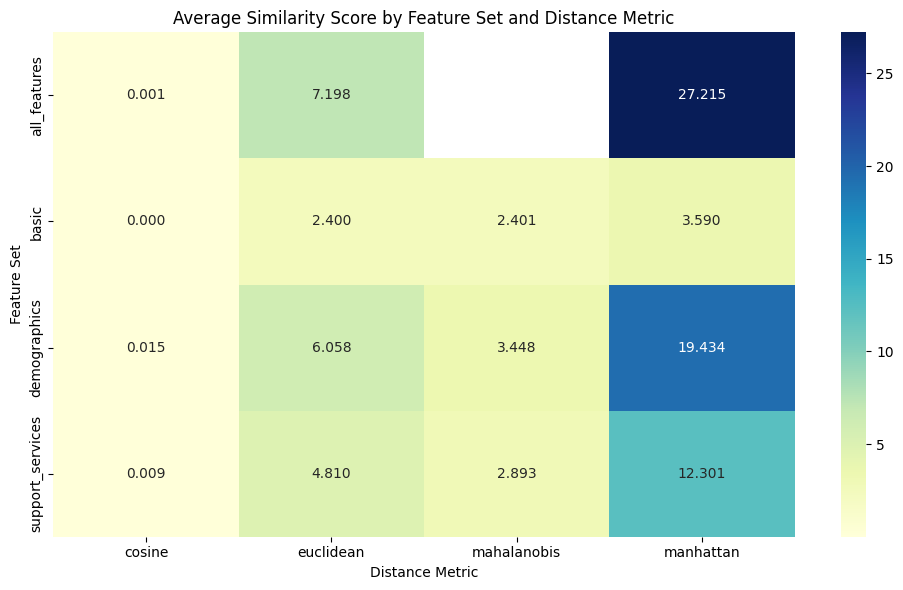

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Average Similarity Score by Feature Set and Distance Metric")
plt.ylabel("Feature Set")
plt.xlabel("Distance Metric")
plt.tight_layout()
plt.show()


In [116]:
best_combo = neighbor_results.groupby(['feature_set', 'distance_metric'])['similarity_score'].mean().idxmin()
print(f"Best combo: Feature set = {best_combo[0]}, Distance metric = {best_combo[1]}")


Best combo: Feature set = basic, Distance metric = cosine


Results  
✅ Cosine (0.0062)  
The best.  

Very low score = neighbors are very close in direction → features vary together.  

Makes sense especially if many features are ratios or percentages.  

✅ Mahalanobis (2.50)  
Takes into account correlation among features.  

Performs well when features are multivariate and linearly related.  

Suggests it's a solid second-best.  

✅ Euclidean (5.12)  
Now a fair competitor. Works well on standardized data.  

May perform even better with fewer dimensions.  

🔻 Manhattan (15.64)  
Still higher, which is expected — Manhattan (L1 norm) is more sensitive to many small deviations across dimensions.  

Often less efficient than Euclidean in high-dimensional, normalized space.  

